In [ ]:
from google.colab import drive
drive.mount('/content/drive')

SAVE_FOLDER = '/content/drive/MyDrive/Projects/modal/dialects_02/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import random
import nltk
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os
import json
import shutil
import numpy as np
from torch.utils.data import Subset # Needed if saving Subset objects


# --- REPRODUCIBILITY FUNCTION ---
def set_seeds(seed_value=42):
    """Set seeds for reproducibility across Python, NumPy, and PyTorch."""
    # 1. Python's random module
    random.seed(seed_value)

    # 2. NumPy
    np.random.seed(seed_value)

    # 3. PyTorch (CPU and GPU)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # For multi-GPU setups

        # 4. CuDNN Configuration (Crucial for LSTM/Convolutional Reproducibility)
        # This forces deterministic algorithms on the GPU, but may slow down training.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    print(f"Global seed set to {seed_value}.")

# --- END REPRODUCIBILITY FUNCTION ---

# ----------------------------------------------------
# ❗ Usage: Call this once near the start of the script
# ----------------------------------------------------
set_seeds(39)


# --- 1. DATA PREPARATION ---
print("Step 1: Preparing NLTK Corpora...")
# (Data preparation code is unchanged)
nltk.download('brown', quiet=True);
nltk.download('gutenberg', quiet=True);
nltk.download('punkt', quiet=True);
nltk.download('inaugural', quiet=True);
nltk.download('webtext', quiet=True)
nltk.download('punkt_tab', quiet = True)

ame_sentences = [" ".join(sent) for sent in nltk.corpus.brown.sents()]
ame_sentences.extend([" ".join(sent) for sent in nltk.corpus.inaugural.sents()])
bre_sentences = []
gutenberg_files = ['austen-persuasion.txt', 'chesterton-ball.txt', 'chesterton-brown.txt']
for fileid in gutenberg_files: bre_sentences.extend([" ".join(sent) for sent in nltk.corpus.gutenberg.sents(fileid)])
webtext_files = ['grail.txt', 'overheard.txt']
for fileid in webtext_files: bre_sentences.extend([" ".join(sent) for sent in nltk.corpus.webtext.sents(fileid)])
BRITISH_FEATURES_HEURISTIC = {'colour', 'favourite', 'realise', 'organise', 'lorry', 'flat', 'whilst', 'centre', 'grey'}
AMERICAN_FEATURES_HEURISTIC = {'color', 'favorite', 'realize', 'organize', 'truck', 'apartment', 'while', 'center', 'gray'}
dialect_to_ix = {"AmE": 0, "BrE": 1, "Neutral": 2}
ix_to_dialect = {v: k for k, v in dialect_to_ix.items()}
full_corpus_3_class = []
full_corpus_raw = [(sent, "AmE") for sent in ame_sentences] + [(sent, "BrE") for sent in bre_sentences]
random.shuffle(full_corpus_raw)
for text, _ in full_corpus_raw:
    has_ame = any(w in text.lower() for w in AMERICAN_FEATURES_HEURISTIC)
    has_bre = any(w in text.lower() for w in BRITISH_FEATURES_HEURISTIC)
    final_label = "Neutral"
    if has_ame and not has_bre: final_label = "AmE"
    elif has_bre and not has_ame: final_label = "BrE"
    full_corpus_3_class.append((text, final_label))
print(f"Total Sentences Created: {len(full_corpus_3_class)}")
word_to_ix = {"<PAD>": 0, "<UNK>": 1}
for sent, _ in full_corpus_3_class:
    for word in sent.lower().split():
        if word not in word_to_ix: word_to_ix[word] = len(word_to_ix)

class DialectDataset(Dataset):
    # (This class is unchanged)
    def __init__(self, corpus_subset, num_classes=3):
        self.data = []
        for text, label in corpus_subset:
            label_ix = dialect_to_ix[label]
            if num_classes == 2 and label_ix == 2: continue
            self.data.append({
                'text': text,
                'tensor': torch.tensor([word_to_ix.get(w, word_to_ix["<UNK>"]) for w in text.lower().split()], dtype=torch.long),
                'label': torch.tensor(label_ix, dtype=torch.long)
            })
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

def collate_fn(batch):
    # (This function is unchanged)
    tensors_padded = nn.utils.rnn.pad_sequence([item['tensor'] for item in batch], batch_first=True, padding_value=word_to_ix["<PAD>"])
    return {
        'texts': [item['text'] for item in batch],
        'tensors': tensors_padded,
        'labels': torch.stack([item['label'] for item in batch])
    }

# --- Data Splitting for Calibration (Unchanged) ---
all_data_size = len(full_corpus_3_class)
train_size = int(0.9 * all_data_size)
test_size = all_data_size - train_size
train_corpus_full, test_corpus_full = random_split(full_corpus_3_class, [train_size, test_size])
train_binary_corpus = [d for d in train_corpus_full if dialect_to_ix[d[1]] != 2]
train_cal_split_size = int(0.7 * len(train_binary_corpus))
cal_split_size = len(train_binary_corpus) - train_cal_split_size
new_train_corpus, calibration_corpus = random_split(train_binary_corpus, [train_cal_split_size, cal_split_size])
test_loader_binary = DataLoader(DialectDataset(test_corpus_full, num_classes=2), batch_size=32, collate_fn=collate_fn)
test_loader_trinary = DataLoader(DialectDataset(test_corpus_full, num_classes=3), batch_size=32, collate_fn=collate_fn)
train_loader_binary = DataLoader(DialectDataset(new_train_corpus, num_classes=2), batch_size=32, shuffle=True, collate_fn=collate_fn)
calibration_loader = DataLoader(DialectDataset(calibration_corpus, num_classes=2), batch_size=32, collate_fn=collate_fn)
pretrain_loader = DataLoader(DialectDataset(train_corpus_full, num_classes=3), batch_size=32, shuffle=True, collate_fn=collate_fn)
print(f"Main training will use {len(train_loader_binary.dataset)} binary (AmE/BrE) sentences.")
print(f"Calibration will use {len(calibration_loader.dataset)} binary (AmE/BrE) sentences.")
print(f"Testing on {len(test_loader_binary.dataset)} binary and {len(test_loader_trinary.dataset)} trinary sentences.")
print("-" * 50)


# --- 2. MODEL DEFINITIONS ---

class VanillaLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128):
        super(VanillaLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word_to_ix["<PAD>"])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.hidden2out = nn.Linear(hidden_dim * 2, 2)
    def forward(self, tensors):
        embeds = self.embedding(tensors)
        _, (hidden, _) = self.lstm(embeds)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.hidden2out(hidden)

class LSTMPropositionPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128):
        super(LSTMPropositionPredictor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word_to_ix["<PAD>"])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.hidden2props = nn.Linear(hidden_dim * 2, 2)
    def forward(self, tensors):
        embeds = self.embedding(tensors)
        lstm_out, _ = self.lstm(embeds)
        props = self.hidden2props(lstm_out)
        return torch.sigmoid(props)

class ModalMLNN(nn.Module):
    """
    An MLNN reasoner that uses Modal Logic to classify sentences.
    It reasons about propositions (HasAmE, HasBrE) across different "worlds"
    representing different levels of certainty.
    """
    def __init__(self, vocab_size, proposition_predictor, **kwargs):
        super(ModalMLNN, self).__init__()
        self.proposition_predictor = proposition_predictor
        # The expert linguist is pre-trained and should not be modified.
        for param in self.proposition_predictor.parameters():
            param.requires_grad = False

    def forward(self, tensors):
        batch_size, seq_len = tensors.shape
        # Handle empty sentences, which are Neutral by the ¬♦(HasAmE) ∧ ¬♦(HasBrE) rule.
        if seq_len == 0:
            return torch.tensor([[0., 0., 1.]]), None, None

        # 1. Get continuous-valued propositions from the expert linguist.
        # This represents the valuation in the 'Real' world (w0).
        predicted_props = self.proposition_predictor(tensors)
        sentence_has_ame_scores = torch.max(predicted_props[:, :, 0], dim=1).values
        sentence_has_bre_scores = torch.max(predicted_props[:, :, 1], dim=1).values

        # 2. Define modal operators based on certainty thresholds.
        # This simulates checking valuations in the 'Skeptical' (w1, threshold > 0.9)
        # and 'Credulous' (w2, threshold > 0.1) worlds.

        # □P ("P is necessarily true") is true iff P is true in ALL accessible worlds (w0, w1, w2).
        # This requires the predictor's confidence to be > 0.9 to satisfy the 'Skeptical' world.
        box_has_ame = (sentence_has_ame_scores > 0.9).float()
        box_has_bre = (sentence_has_bre_scores > 0.9).float()

        # ♦P ("P is possibly true") is true iff P is true in AT LEAST ONE accessible world.
        # This only requires the confidence to be > 0.1 to satisfy the 'Credulous' world.
        diamond_has_ame = (sentence_has_ame_scores > 0.1).float()
        diamond_has_bre = (sentence_has_bre_scores > 0.1).float()

        # 3. Apply the modal axioms to deduce the final class.
        # Rule for AmE: □(HasAmE) ∧ ¬♦(HasBrE) → IsAmE
        # "It's necessarily American and not possibly British."
        is_ame_class_truth = box_has_ame * (1.0 - diamond_has_bre)

        # Rule for BrE: □(HasBrE) ∧ ¬♦(HasAmE) → IsBrE
        # "It's necessarily British and not possibly American."
        is_bre_class_truth = box_has_bre * (1.0 - diamond_has_ame)

        # Rule for Neutral: (♦(HasAmE) ∧ ♦(HasBrE)) ∨ (¬♦(HasAmE) ∧ ¬♦(HasBrE)) → IsNeutral
        # "It's possibly both (mixed), OR it's not possibly either (no features)."
        mixed_features = diamond_has_ame * diamond_has_bre
        no_features = (1.0 - diamond_has_ame) * (1.0 - diamond_has_bre)
        is_neutral_class_truth = mixed_features + no_features

        # Stack the final truth values for each class.
        final_class_truths = torch.stack([is_ame_class_truth, is_bre_class_truth, is_neutral_class_truth], dim=1)

        return final_class_truths, None, None


class ConformalModel:
    # (This class is unchanged)
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.q_hat = None

    def calibrate(self, calibration_loader, alpha=0.05):
        # print(f"Calibrating Conformal Model with alpha={alpha}...") # Silenced for plotting
        scores = []
        with torch.no_grad():
            for batch in calibration_loader: # Removed tqdm for cleaner plotting output
                tensors = batch['tensors']
                labels = batch['labels']
                logits = self.model(tensors)
                probs = torch.softmax(logits, dim=1)
                correct_class_probs = probs[torch.arange(len(labels)), labels]
                non_conformity_scores = 1.0 - correct_class_probs
                scores.extend(non_conformity_scores.tolist())
        n = len(scores)
        q_level = np.ceil((n + 1) * (1 - alpha)) / n
        q_level = min(1.0, max(0.0, q_level))
        self.q_hat = np.quantile(scores, q_level)
        # print(f"Calibration complete. n={n}, alpha={alpha}, q_hat={self.q_hat:.4f}") # Silenced
        return self.q_hat

    def predict_sets(self, tensors):
        if self.q_hat is None:
            raise ValueError("Model must be calibrated before prediction.")
        with torch.no_grad():
            logits = self.model(tensors)
            probs = torch.softmax(logits, dim=1)
            prediction_sets = (probs > (1.0 - self.q_hat)).tolist()
            final_sets = []
            for set_bools in prediction_sets:
                final_sets.append([i for i, included in enumerate(set_bools) if included])
            return final_sets


# --- 3. TRAINING PROCEDURES ---

def pretrain_predictor(loader, vocab_size, epochs=8):
    print("\n--- STAGE 1: Pre-training Proposition Predictor (Expert Linguist) ---")
    print("Using powerful LSTMPropositionPredictor as expert.")
    model = LSTMPropositionPredictor(vocab_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCELoss()
    for epoch in range(epochs):
        model.train()
        loop = tqdm(loader, desc=f"Predictor Epoch {epoch+1}/{epochs}")
        for batch in loop:
            tensors = batch['tensors']
            targets = torch.zeros(tensors.shape[0], tensors.shape[1], 2, device=tensors.device)
            for i, text in enumerate(batch['texts']):
                words = text.lower().split()
                for j, word in enumerate(words):
                    if j < targets.shape[1]:
                        if word in AMERICAN_FEATURES_HEURISTIC: targets[i, j, 0] = 1.0
                        if word in BRITISH_FEATURES_HEURISTIC: targets[i, j, 1] = 1.0
            optimizer.zero_grad()
            outputs = model(tensors)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())
    return model

def train_baseline(loader, vocab_size, epochs=3):
    print("\n--- Training Baseline LSTM (on AmE/BrE only) ---")
    model = VanillaLSTM(vocab_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        loop = tqdm(loader, desc=f"Baseline Epoch {epoch+1}/{epochs}")
        for batch in loop:
            optimizer.zero_grad()
            outputs = model(batch['tensors'])
            loss = loss_fn(outputs, batch['labels'])
            loss.backward()
            optimizer.step()
    return model

def train_mlnn_reasoner(loader, predictor, vocab_size, epochs=3):
    print("\n--- STAGE 2: Training Modal MLNN Reasoner (on AmE/BrE only) ---")
    model = ModalMLNN(vocab_size, predictor)
    learnable_params = list(filter(lambda p: p.requires_grad, model.parameters()))
    if not learnable_params:
        print("Modal MLNN has no learnable parameters, as expected for this experiment. Skipping training.")
        return model
    # (Rest of the function is unchanged, but won't be called)
    optimizer = optim.Adam(learnable_params, lr=0.001)
    for epoch in range(epochs):
        model.train()
        loop = tqdm(loader, desc=f"Modal MLNN Epoch {epoch+1}/{epochs}")
        for batch in loop:
            optimizer.zero_grad()
            final_truths, _, _ = model(batch['tensors'])
            labels_one_hot = nn.functional.one_hot(batch['labels'], num_classes=2).float()
            loss = torch.mean((final_truths[:, :2] - labels_one_hot)**2)
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())
    return model

# --- 4. EVALUATION (Unchanged) ---
def evaluate(model, loader, model_type, num_classes):
    model.eval()
    all_true_labels, all_preds = [], []
    with torch.no_grad():
        for batch in loader:
            outputs = model(batch['tensors'])
            if model_type == 'mlnn':
                outputs = outputs[0]
            preds = torch.argmax(outputs, dim=1)
            all_true_labels.extend(batch['labels'].numpy())
            all_preds.extend(preds.numpy())
    report_labels = range(num_classes)
    target_names = ["AmE", "BrE", "Neutral"][:num_classes]
    if model_type == 'lstm' and num_classes == 3:
        report_labels = sorted(list(set(all_true_labels)))
        target_names = [ix_to_dialect.get(l, f"Unknown_{l}") for l in report_labels]
    print(f"\nConfusion Matrix:\n")
    print(confusion_matrix(all_true_labels, all_preds, labels=report_labels))
    print(f"\nClassification Report:\n")
    print(classification_report(all_true_labels, all_preds, labels=report_labels, target_names=target_names, zero_division=0))


def evaluate_cp(conformal_model, loader, alpha=0.05):
    # (This function is unchanged)
    print(f"\n--- (NEW) BiLSTM + CP (alpha = {alpha}) evaluated on AmE/BrE/Neutral ---")
    conformal_model.calibrate(calibration_loader, alpha=alpha)
    print(f"Calibration complete. n={len(calibration_loader.dataset)}, alpha={alpha}, q_hat={conformal_model.q_hat:.4f}")
    all_true_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in loader:
            tensors = batch['tensors']
            labels = batch['labels']
            prediction_sets = conformal_model.predict_sets(tensors)
            for set_i in prediction_sets:
                if len(set_i) == 1:
                    all_preds.append(set_i[0])
                else:
                    all_preds.append(dialect_to_ix["Neutral"])
            all_true_labels.extend(labels.numpy())
    num_classes = 3
    report_labels = range(num_classes)
    target_names = ["AmE", "BrE", "Neutral"]
    print(f"\nConfusion Matrix:\n")
    print(confusion_matrix(all_true_labels, all_preds, labels=report_labels))
    print(f"\nClassification Report (to fill Table 2):\n")
    print(classification_report(all_true_labels, all_preds, labels=report_labels, target_names=target_names, zero_division=0))


# --- 5. MAIN EXECUTION ---
if __name__ == "__main__":
    vocab_size = len(word_to_ix)

    # STAGE 1
    proposition_predictor = pretrain_predictor(pretrain_loader, vocab_size)

    # STAGE 2
    baseline_lstm = train_baseline(train_loader_binary, vocab_size)
    modal_mlnn = train_mlnn_reasoner(train_loader_binary, proposition_predictor, vocab_size)
    conformal_baseline = ConformalModel(baseline_lstm)

    # STAGE 3
    print("\n" + "="*80)
    print(" " * 25 + "FINAL MODEL COMPARISON RESULTS")
    print("="*80)

    print("\n(1) Baseline LSTM evaluated on AmE/BrE only:")
    evaluate(baseline_lstm, test_loader_binary, 'lstm', num_classes=2)

    print("\n" + "-"*80)
    print("\n(2) Baseline LSTM evaluated on AmE/BrE/Neutral (forced to guess):")
    evaluate(baseline_lstm, test_loader_trinary, 'lstm', num_classes=3)

    print("\n" + "-"*80)
    evaluate_cp(conformal_baseline, test_loader_trinary, alpha=0.05)

    print("\n" + "-"*80)
    print("\n(3) Modal MLNN evaluated on AmE/BrE only:")
    evaluate(modal_mlnn, test_loader_binary, 'mlnn', num_classes=2)

    print("\n" + "-"*80)
    print("\n(4) Modal MLNN (using Modal Logic) evaluated on AmE/BrE/Neutral:")
    evaluate(modal_mlnn, test_loader_trinary, 'mlnn', num_classes=3)

Global seed set to 39.
Step 1: Preparing NLTK Corpora...
Total Sentences Created: 94887
Main training will use 1771 binary (AmE/BrE) sentences.
Calibration will use 759 binary (AmE/BrE) sentences.
Testing on 282 binary and 9489 trinary sentences.
--------------------------------------------------

--- STAGE 1: Pre-training Proposition Predictor (Expert Linguist) ---
Using powerful LSTMPropositionPredictor as expert.


Predictor Epoch 8/8: 100%|██████████| 2669/2669 [07:07<00:00,  6.25it/s, loss=4.79e-10]



--- Training Baseline LSTM (on AmE/BrE only) ---


Baseline Epoch 3/3: 100%|██████████| 56/56 [00:06<00:00,  8.63it/s]



--- STAGE 2: Training Modal MLNN Reasoner (on AmE/BrE only) ---
Modal MLNN has no learnable parameters, as expected for this experiment. Skipping training.

                         FINAL MODEL COMPARISON RESULTS

(1) Baseline LSTM evaluated on AmE/BrE only:

Confusion Matrix:

[[239   5]
 [ 25  13]]

Classification Report:

              precision    recall  f1-score   support

         AmE       0.91      0.98      0.94       244
         BrE       0.72      0.34      0.46        38

    accuracy                           0.89       282
   macro avg       0.81      0.66      0.70       282
weighted avg       0.88      0.89      0.88       282


--------------------------------------------------------------------------------

(2) Baseline LSTM evaluated on AmE/BrE/Neutral (forced to guess):

Confusion Matrix:

[[ 237    7    0]
 [  25   13    0]
 [8848  359    0]]

Classification Report:

              precision    recall  f1-score   support

         AmE       0.03      0.97      0.


--- Generating Risk-Coverage Plot ---
Sweeping alpha for CP model...


Plotting CP: 100%|██████████| 50/50 [03:36<00:00,  4.33s/it]


Calculating Modal MLNN operating point...


Calculating MLNN Point: 100%|██████████| 297/297 [00:04<00:00, 70.13it/s]


Modal MLNN Point: Coverage=0.0208, Risk=0.0000
Risk-Coverage plot saved to risk_coverage_curve_modal.pdf


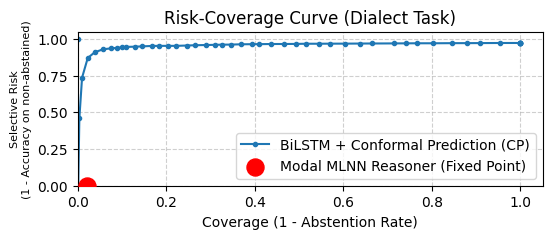

In [ ]:
def generate_risk_coverage_plot(conformal_model, mlnn_model, loader):
    """
    Generates the Risk-Coverage plot.
    - Sweeps alpha for the CP model to get a curve.
    - Calculates the single operating point for the MLNN.
    """
    print("\n--- Generating Risk-Coverage Plot ---")

    cp_alphas = np.linspace(0.01, 1.0, 50)
    cp_risks = []
    cp_coverages = []

    print("Sweeping alpha for CP model...")
    for alpha in tqdm(cp_alphas, desc="Plotting CP"):
        conformal_model.calibrate(calibration_loader, alpha=alpha)
        all_true = []
        all_sets = []
        with torch.no_grad():
            for batch in loader:
                all_true.extend(batch['labels'].tolist())
                all_sets.extend(conformal_model.predict_sets(batch['tensors']))
        num_predictions = len(all_true)
        num_abstained = 0
        num_correct_non_abstained = 0
        for y_true, set_pred in zip(all_true, all_sets):
            if len(set_pred) == 0:
                num_abstained += 1
            else:
                if y_true in set_pred:
                    num_correct_non_abstained += 1
        num_non_abstained = num_predictions - num_abstained
        if num_non_abstained == 0:
            coverage = 0.0
            selective_accuracy = 0.0
        else:
            coverage = num_non_abstained / num_predictions
            selective_accuracy = num_correct_non_abstained / num_non_abstained
        risk = 1.0 - selective_accuracy
        cp_coverages.append(coverage)
        cp_risks.append(risk)

    print("Calculating Modal MLNN operating point...")
    all_true = []
    all_pred_labels = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Calculating MLNN Point"):
            tensors = batch['tensors']
            labels = batch['labels']
            outputs = mlnn_model(tensors)[0]
            preds = torch.argmax(outputs, dim=1)
            all_true.extend(labels.tolist())
            all_pred_labels.extend(preds.tolist())

    num_predictions = len(all_true)
    num_abstained = 0
    num_correct_non_abstained = 0
    for y_true, y_pred in zip(all_true, all_pred_labels):
        if y_pred == dialect_to_ix["Neutral"]:
            num_abstained += 1
        else:
            if y_true == y_pred:
                num_correct_non_abstained += 1
    num_non_abstained = num_predictions - num_abstained
    mlnn_coverage = num_non_abstained / num_predictions
    mlnn_selective_accuracy = num_correct_non_abstained / num_non_abstained if num_non_abstained > 0 else 0
    mlnn_risk = 1.0 - mlnn_selective_accuracy
    print(f"Modal MLNN Point: Coverage={mlnn_coverage:.4f}, Risk={mlnn_risk:.4f}")

    plt.figure(figsize=(6, 2))
    plt.plot(cp_coverages, cp_risks, marker='.', linestyle='-', label='BiLSTM + Conformal Prediction (CP)')
    plt.scatter([mlnn_coverage], [mlnn_risk], color='red', s=150, zorder=5, label=f'Modal MLNN Reasoner (Fixed Point)')
    plt.xlabel('Coverage (1 - Abstention Rate)')
    plt.ylabel('Selective Risk\n(1 - Accuracy on non-abstained)', fontsize = 8)
    plt.title('Risk-Coverage Curve (Dialect Task)')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0, 1.05)
    plt.ylim(0, 1.05)
    plot_filename = 'risk_coverage_curve_modal.pdf'
    plt.savefig(plot_filename)
    print(f"Risk-Coverage plot saved to {plot_filename}")


generate_risk_coverage_plot(conformal_baseline, modal_mlnn, test_loader_trinary)

In [ ]:
def save_list_to_jsonl(data_container, filename):
    """
    Saves data from a DataLoader, Subset, or a list of (text, label) tuples
    to a JSON lines file for persistence.
    """
    data_list = []

    # 1. Handle DataLoader (extracts the dataset)
    if isinstance(data_container, torch.utils.data.DataLoader):
        data_container = data_container.dataset

    # 2. Handle Subset (extracts data using indices)
    if isinstance(data_container, torch.utils.data.Subset):
        # We need the original dataset and the subset indices
        original_dataset = data_container.dataset
        data_list = [original_dataset[i] for i in tqdm(data_container.indices, desc=f"Writing {os.path.basename(filename)}")]

    # 3. Handle DialectDataset (extracts the internal data list)
    elif hasattr(data_container, 'data') and isinstance(data_container.data, list):
         # This catches instances of the raw DialectDataset object
        data_list = data_container.data

    # 4. Handle Direct List of (text, label) tuples (Fallback)
    elif isinstance(data_container, list) and data_container and isinstance(data_container[0], tuple):
        data_list = data_container

    # Final check: ensure the list contains the dict format for saving
    if data_list and isinstance(data_list[0], dict):
        # Already in the preferred dictionary format from DialectDataset
        final_list = data_list
    elif data_list and isinstance(data_list[0], tuple):
        # Convert (text, label) tuples (from random_split) into the preferred dict format
        final_list = [{'text': item[0], 'label': item[1]} for item in data_list]
    else:
        # Avoid raising an error for empty data splits if the logic above failed
        final_list = []

    with open(filename, 'w') as f:
        for item in final_list:
            f.write(json.dumps(item) + '\n')

print("="*80)
print("--- STARTING RESULTS PERSISTENCE ---")

# --- 1. Directory Setup ---
if os.path.exists(SAVE_FOLDER):
    print(f"Directory {SAVE_FOLDER} already exists. Deleting and recreating.")
    # WARNING: shutil.rmtree will permanently delete files in the target directory.
    # Ensure this is safe in your environment (e.g., if SAVE_FOLDER is on MyDrive).
    shutil.rmtree(SAVE_FOLDER)
os.makedirs(SAVE_FOLDER)
print(f"Saving all results to: {SAVE_FOLDER}")


# --- 2. Save Models (State Dictionaries) ---
try:
    torch.save(proposition_predictor.state_dict(), os.path.join(SAVE_FOLDER, 'predictor_expert.pth'))
    torch.save(baseline_lstm.state_dict(), os.path.join(SAVE_FOLDER, 'baseline_lstm.pth'))
    torch.save(modal_mlnn.state_dict(), os.path.join(SAVE_FOLDER, 'advanced_mlnn.pth'))
    print("- Models (PTH state dictionaries) saved.")
except NameError:
    print("WARNING: Model variables not found. Skipping model save.")


# --- 3. Save Dictionaries and Mappings ---
try:
    with open(os.path.join(SAVE_FOLDER, 'word_to_ix.json'), 'w') as f:
        json.dump(word_to_ix, f)
    with open(os.path.join(SAVE_FOLDER, 'dialect_mappings.json'), 'w') as f:
        json.dump({'dialect_to_ix': dialect_to_ix, 'ix_to_dialect': ix_to_dialect}, f)
    print("- Vocabulary and Dialect Mappings (JSON) saved.")
except NameError:
    print("WARNING: Vocabulary variables not found. Skipping vocab save.")


# --- 3.5 Save Conformal Prediction Parameters (CP Model) ---
try:
    # We save the critical q_hat value after the calibration step in evaluate_cp()
    q_hat_value = conformal_baseline.q_hat

    cp_params = {
        'q_hat': q_hat_value,
        'alpha_used': 0.05,
        'calibration_size': len(calibration_loader.dataset)
    }
    with open(os.path.join(SAVE_FOLDER, 'cp_calibration_params.json'), 'w') as f:
        json.dump(cp_params, f)

    print("- Conformal Prediction (CP) calibration parameters (q_hat) saved.")
except NameError:
    print("WARNING: Conformal Model variable not found. Skipping CP parameter save.")
except AttributeError:
     print("WARNING: 'conformal_baseline' exists but was not calibrated (q_hat is None). Skipping CP parameter save.")


# --- 4. Save Data Splits (Raw Sentences/Labels) ---
try:
    # These save the full lists of (text, label) tuples.
    save_list_to_jsonl(train_corpus_full, os.path.join(SAVE_FOLDER, 'train_corpus_full.jsonl'))
    save_list_to_jsonl(test_corpus_full, os.path.join(SAVE_FOLDER, 'test_corpus_full.jsonl'))
    save_list_to_jsonl(new_train_corpus, os.path.join(SAVE_FOLDER, 'new_train_corpus_binary.jsonl'))
    save_list_to_jsonl(calibration_corpus, os.path.join(SAVE_FOLDER, 'calibration_corpus_binary.jsonl'))

    print("- Data Splits (JSONL files) saved. (Total: ~9489 sentences + binary subsets)")
except Exception as e:
     print(f"CRITICAL: Failed to save data splits due to error: {e}")

print("--- RESULTS PERSISTENCE COMPLETE ---")

--- STARTING RESULTS PERSISTENCE ---
Directory /content/drive/MyDrive/Projects/modal/dialects_02/ already exists. Deleting and recreating.
Saving all results to: /content/drive/MyDrive/Projects/modal/dialects_02/
- Models (PTH state dictionaries) saved.
- Vocabulary and Dialect Mappings (JSON) saved.
- Conformal Prediction (CP) calibration parameters (q_hat) saved.


Writing calibration_corpus_binary.jsonl: 100%|██████████| 759/759 [00:00<00:00, 2017412.38it/s]

- Data Splits (JSONL files) saved. (Total: ~9489 sentences + binary subsets)
--- RESULTS PERSISTENCE COMPLETE ---


In [ ]:
!cp /content/*.pdf /content/drive/MyDrive/Projects/modal/dialects_02/
!ls /content/drive/MyDrive/Projects/modal/dialects_02/*

/content/drive/MyDrive/Projects/modal/dialects_02/advanced_mlnn.pth
/content/drive/MyDrive/Projects/modal/dialects_02/baseline_lstm.pth
/content/drive/MyDrive/Projects/modal/dialects_02/calibration_corpus_binary.jsonl
/content/drive/MyDrive/Projects/modal/dialects_02/cp_calibration_params.json
/content/drive/MyDrive/Projects/modal/dialects_02/dialect_mappings.json
/content/drive/MyDrive/Projects/modal/dialects_02/new_train_corpus_binary.jsonl
/content/drive/MyDrive/Projects/modal/dialects_02/predictor_expert.pth
/content/drive/MyDrive/Projects/modal/dialects_02/risk_coverage_curve_modal.pdf
/content/drive/MyDrive/Projects/modal/dialects_02/test_corpus_full.jsonl
/content/drive/MyDrive/Projects/modal/dialects_02/train_corpus_full.jsonl
/content/drive/MyDrive/Projects/modal/dialects_02/word_to_ix.json
